In [2]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Load & Chcek Null

In [3]:
dir = Path("./docs/")
train_file_path = dir.joinpath("fraud.csv")
test_file_path = dir.joinpath("no_label.csv")
ip_file_path = dir.joinpath("ip_country.xlsx")

# File Load
train = pd.read_csv(train_file_path, index_col=0)
test = pd.read_csv(test_file_path, index_col=0)
ip = pd.read_excel(ip_file_path)

In [4]:
# Ensure Only First Buying
train["user_id"].value_counts()

user_id
285108    1
375847    1
340683    1
302338    1
47270     1
         ..
170034    1
87898     1
180229    1
290767    1
341401    1
Name: count, Length: 120000, dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 149671 to 46646
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         120000 non-null  int64  
 1   signup_time     120000 non-null  object 
 2   purchase_time   120000 non-null  object 
 3   purchase_value  120000 non-null  int64  
 4   device_id       120000 non-null  object 
 5   source          120000 non-null  object 
 6   browser         120000 non-null  object 
 7   sex             120000 non-null  object 
 8   age             120000 non-null  int64  
 9   ip_address      120000 non-null  float64
 10  class           120000 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 11.0+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31112 entries, 6 to 151105
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         31112 non-null  int64  
 1   signup_time     31112 non-null  object 
 2   purchase_time   31112 non-null  object 
 3   purchase_value  31112 non-null  int64  
 4   device_id       31112 non-null  object 
 5   source          31112 non-null  object 
 6   browser         31112 non-null  object 
 7   sex             31112 non-null  object 
 8   age             31112 non-null  int64  
 9   ip_address      31112 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.6+ MB


# Convert str to datetime & mapping ip country

In [7]:
def to_datetime(x, for_test=False):
    if for_test:
        time_format = "%Y-%m-%d %H:%M"
    else:
        time_format = "%m/%d/%Y %H:%M"
    return datetime.strptime(x, time_format)

def to_minuets(x):
    return x.total_seconds() / 60

def find_country(number, df):
    country = df[(df['lower_bound_ip_address'] <= number) & (df['upper_bound_ip_address'] >= number)]['country']
    return country.iloc[0] if not country.empty else "Unknown"


# To datetime
train["signup_time"] = train["signup_time"].apply(to_datetime)
train["purchase_time"] = train["purchase_time"].apply(to_datetime)
test["signup_time"] = test["signup_time"].apply(lambda x: to_datetime(x, for_test=True))
test["purchase_time"] = test["purchase_time"].apply(lambda x: to_datetime(x, for_test=True))

#
train.insert(loc=3, column="time_delta", value=None)
test.insert(loc=3, column="time_delta", value=None)

# # Time sub
train["time_delta"] = train["purchase_time"] - train["signup_time"]
train["time_delta"] = train["time_delta"].apply(to_minuets)
test["time_delta"] = test["purchase_time"] - test["signup_time"]
test["time_delta"] = test["time_delta"].apply(to_minuets)

#
train.insert(loc=11, column="ip_country", value=None)
test.insert(loc=11, column="ip_country", value=None)
#
train["ip_country"] = train["ip_address"].apply(lambda x : find_country(x, ip))
test["ip_country"] = test["ip_address"].apply(lambda x : find_country(x, ip))

# Distribution

array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'signup_time'}>,
        <Axes: title={'center': 'purchase_time'}>],
       [<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_address'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

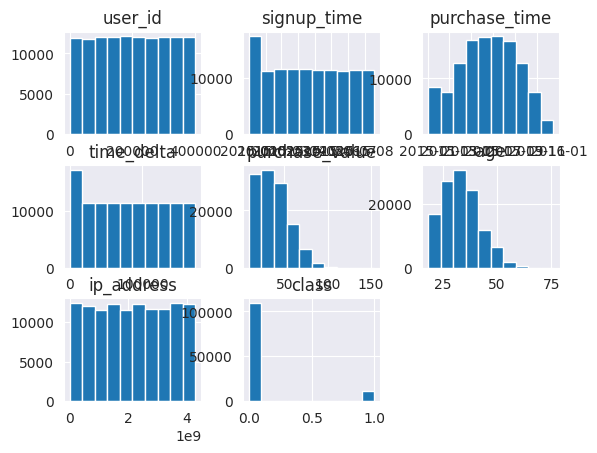

In [27]:
train.hist(bins=10)


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'signup_time'}>,
        <Axes: title={'center': 'purchase_time'}>],
       [<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_address'}>, <Axes: >, <Axes: >]],
      dtype=object)

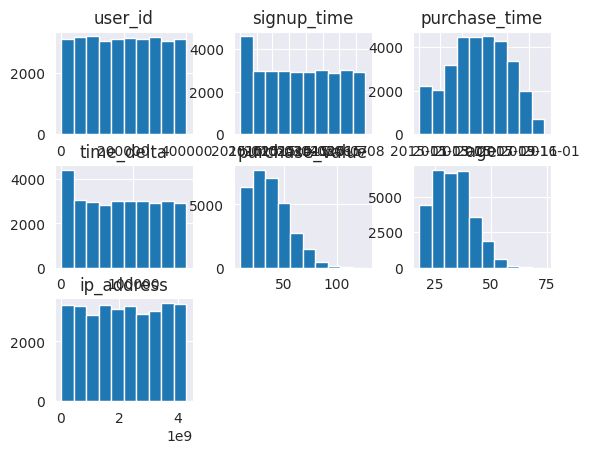

In [30]:
test.hist(bins=10)

In [31]:
fraud = train[train["class"] == 1]
non_fraud = train[train["class"] == 0]

array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'signup_time'}>,
        <Axes: title={'center': 'purchase_time'}>],
       [<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_address'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

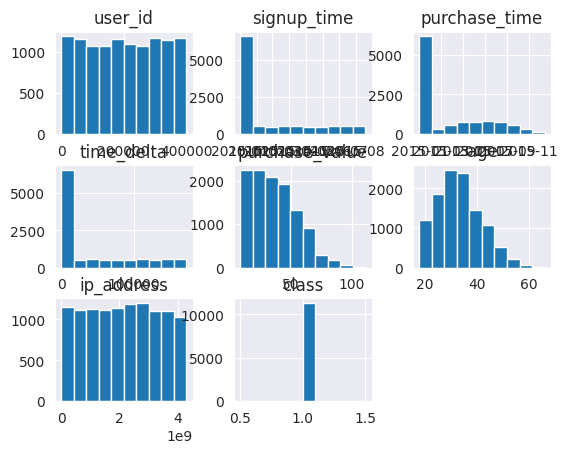

In [32]:
fraud.hist(bins=10)

array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'signup_time'}>,
        <Axes: title={'center': 'purchase_time'}>],
       [<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_address'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

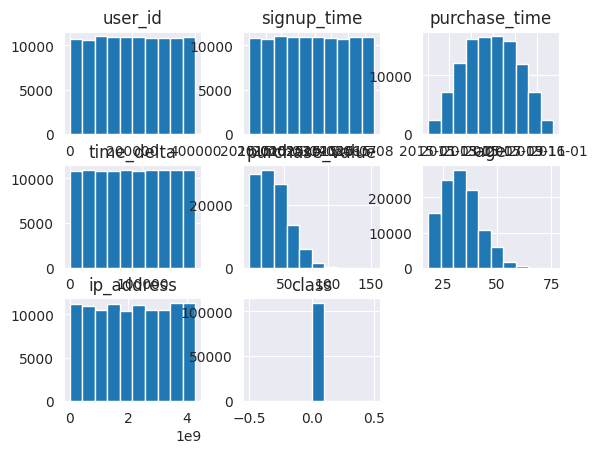

In [33]:
non_fraud.hist(bins=10)

You can see that "ip_address" very different when fraud

# Drop unnecessary

In [39]:
try:
    to_drop_column = ["user_id", "signup_time", "purchase_time", "device_id", "ip_address"]
    train = train.drop(to_drop_column, axis=1)
    test = test.drop(to_drop_column, axis=1)
except:
    pass

fraud = train[train["class"] == 1]
non_fraud = train[train["class"] == 0]

array([[<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'class'}>]], dtype=object)

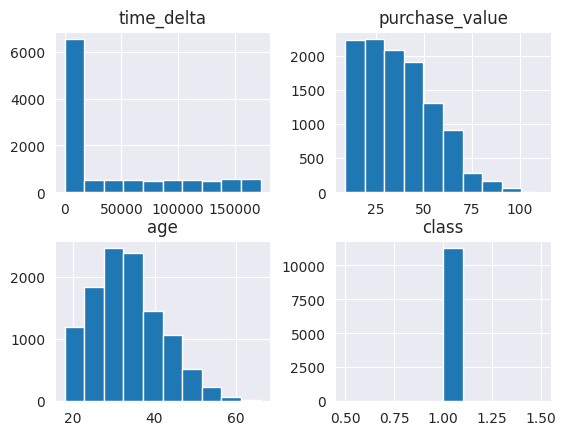

In [40]:
fraud.hist()

You can see fraud transaction low time_delta

array([[<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'class'}>]], dtype=object)

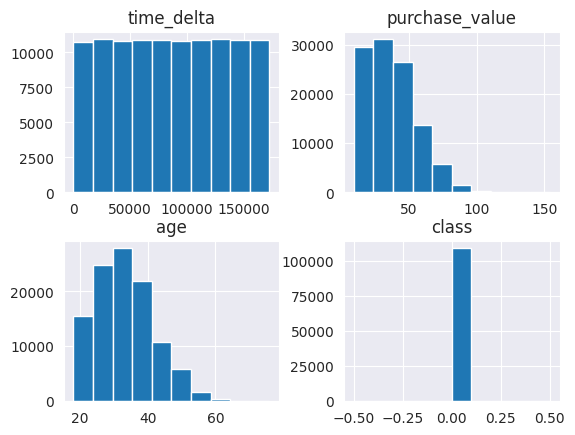

In [42]:
non_fraud.hist()

In [43]:
# To numerical

In [44]:
def get_map(category, df):
    dic = {}
    temp = df[category].drop_duplicates()
    temp_array = temp.values
    for i, x in enumerate(temp_array):
        dic[x] = i
    return dic

source_map = get_map("source", df=train)
browser_map = get_map("browser", df=train)
sex_map = get_map("sex", df=train)
country_map = get_map("ip_country", df=train)

train["source"] = train["source"].map(source_map)
train["browser"] = train["browser"].map(browser_map)
train["sex"] = train["sex"].map(sex_map)
train["ip_country"] = train["ip_country"].map(country_map)

test["source"] = test["source"].map(source_map)
test["browser"] = test["browser"].map(browser_map)
test["sex"] = test["sex"].map(sex_map)
test["ip_country"] = test["ip_country"].map(country_map)


In [46]:
fraud = train[train["class"] == 1]
non_fraud = train[train["class"] == 0]

In [21]:
# Split files
fraud = train[train["class"] == 1]
non_fraud = train[train["class"] == 0]

array([[<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'source'}>],
       [<Axes: title={'center': 'browser'}>,
        <Axes: title={'center': 'sex'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_country'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

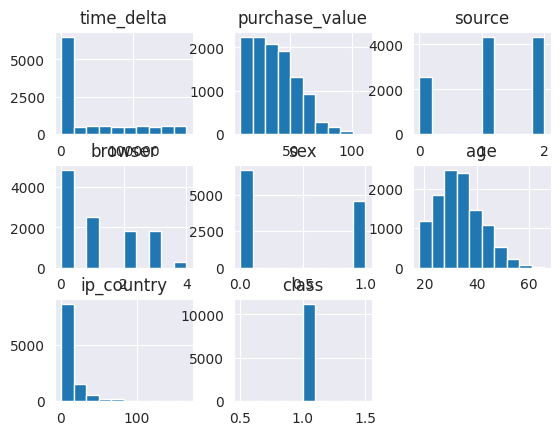

In [47]:
fraud.hist()

array([[<Axes: title={'center': 'time_delta'}>,
        <Axes: title={'center': 'purchase_value'}>,
        <Axes: title={'center': 'source'}>],
       [<Axes: title={'center': 'browser'}>,
        <Axes: title={'center': 'sex'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'ip_country'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

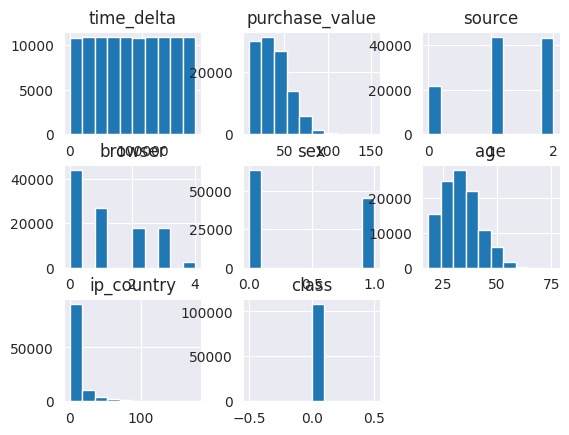

In [48]:
non_fraud.hist()